In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the EncDec-AD model

In [2]:
# decoder input: original time series value at last time step

class EncDecAD(object):

    def __init__(self, hidden_num, inputs, cell=None, optimizer=None, reverse=True, decode_without_input=False,):

        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
        
        if cell is None:
            self._enc_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
            self._dec_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)

        else:
            self._enc_cell = cell
            self._dec_cell = cell

        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)

        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight')

            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32), name='dec_bias')

            if decode_without_input:
                dec_inputs = [tf.zeros(tf.shape(inputs[0]),dtype=tf.float32) for _ in range(len(inputs))]
                (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state, dtype=tf.float32)

                if reverse:
                    dec_outputs = dec_outputs[::-1]
                    
                dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,2])
                dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),[self.batch_num, 1, 1])
                self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_


            else:
                dec_state = self.enc_state
                dec_input_ = tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)
                dec_outputs = []
                
                for step in range(len(inputs)):
                    if step > 0:
                        vs.reuse_variables()
                    (dec_input_, dec_state) =self._dec_cell(dec_input_, dec_state)
                    dec_input_ = tf.matmul(dec_input_, dec_weight_) + dec_bias_
                    dec_outputs.append(dec_input_)

                if reverse:
                    dec_outputs = dec_outputs[::-1]

                self.output_ = tf.transpose(tf.stack(dec_outputs), [1, 0, 2])
        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_))

        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

        else:
            self.train = optimizer.minimize(self.loss)
        

# Load Power Demand Dataset

In [3]:
# The dataset is divided into 6 parts, namely training_normal, validation_1,
#validation_2, test_normal, validation_anomaly, test_anomaly.

root = "C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/preprocessed/PowerDemand/6_subsets/"

sn = pd.read_csv(root + "training_normal.csv",header=None)
vn1 = pd.read_csv(root + "validation_1.csv",header=None)
vn2 = pd.read_csv(root + "validation_2.csv",header=None)
tn = pd.read_csv(root + "test_normal.csv",header=None)

va = pd.read_csv(root + "validation_anomaly.csv",header=None)
ta = pd.read_csv(root + "test_anomaly.csv",header=None)    


# Initialization

In [4]:
tf.reset_default_graph()

batch_num = 3

hidden_num = 40

step_num = 84

elem_num = sn.shape[1]

iteration = 5000

modlepath = "C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt"

In [5]:
t1 = sn.shape[0]//step_num
t2 = va.shape[0]//step_num
t3 = vn1.shape[0]//step_num
t4 = vn2.shape[0]//step_num
t5 = tn.shape[0]//step_num
t6 = ta.shape[0]//step_num

sn_list = [sn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t1)]
va_list = [va[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t2)]
vn1_list = [vn1[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t3)]
vn2_list = [vn2[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t4)]

tn_list = [tn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t5)]
ta_list = [ta[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t6)]


In [6]:
# input placeholder
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]

# define cell
#cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
cell = None

In [7]:
ae = EncDecAD(hidden_num, p_inputs,cell=cell,
                     decode_without_input=False)

# Training

iter 1: 0.10634
iter 2: 0.0852652
iter 3: 0.0834084
iter 4: 0.0368854
iter 5: 0.0400195
iter 6: 0.0559024
iter 7: 0.0496151
iter 8: 0.0385302
iter 9: 0.0345894
iter 10: 0.0465101
iter 11: 0.0496321
iter 12: 0.0405332
iter 13: 0.0538201
iter 14: 0.0412132
iter 15: 0.0467909
iter 16: 0.0384933
iter 17: 0.0365153
iter 18: 0.0381242
iter 19: 0.0402842
iter 20: 0.0352381
iter 21: 0.037352
iter 22: 0.0383866
iter 23: 0.0315591
iter 24: 0.0389019
iter 25: 0.037426
iter 26: 0.0312505
iter 27: 0.0370146
iter 28: 0.0456627
iter 29: 0.0431333
iter 30: 0.0365291
iter 31: 0.0379719
iter 32: 0.0384575
iter 33: 0.03669
iter 34: 0.0376086
iter 35: 0.0361799
iter 36: 0.0324514
iter 37: 0.0324456
iter 38: 0.0386105
iter 39: 0.0399762
iter 40: 0.0473634
iter 41: 0.0361863
iter 42: 0.033167
iter 43: 0.0337156
iter 44: 0.029879
iter 45: 0.0391015
iter 46: 0.0314526
iter 47: 0.0352605
iter 48: 0.0353136
iter 49: 0.0346372
iter 50: 0.0340228
iter 51: 0.0349461
iter 52: 0.0312138
iter 53: 0.0334751
iter 54: 0

iter 419: 0.0310151
iter 420: 0.0340066
iter 421: 0.0335822
iter 422: 0.0349237
iter 423: 0.0350065
iter 424: 0.0296463
iter 425: 0.0376504
iter 426: 0.037595
iter 427: 0.0344701
iter 428: 0.0344997
iter 429: 0.0326917
iter 430: 0.0321996
iter 431: 0.0319761
iter 432: 0.0285477
iter 433: 0.0333272
iter 434: 0.0308659
iter 435: 0.0366703
iter 436: 0.0278874
iter 437: 0.028713
iter 438: 0.0295312
iter 439: 0.0260989
iter 440: 0.0323188
iter 441: 0.0342767
iter 442: 0.0334863
iter 443: 0.0343784
iter 444: 0.0437882
iter 445: 0.0362123
iter 446: 0.0318516
iter 447: 0.0340227
iter 448: 0.0320247
iter 449: 0.0359815
iter 450: 0.0352568
iter 451: 0.0304945
iter 452: 0.032784
iter 453: 0.0385362
iter 454: 0.0340198
iter 455: 0.0399579
iter 456: 0.0313721
iter 457: 0.0393403
iter 458: 0.0292614
iter 459: 0.0322325
iter 460: 0.0359895
iter 461: 0.0334204
iter 462: 0.0298616
iter 463: 0.0332015
iter 464: 0.039306
iter 465: 0.0318101
iter 466: 0.0357299
iter 467: 0.0344741
iter 468: 0.0299748
iter

iter 830: 0.00523446
iter 831: 0.00933358
iter 832: 0.00517343
iter 833: 0.00766704
iter 834: 0.00737661
iter 835: 0.00780312
iter 836: 0.00560462
iter 837: 0.00563453
iter 838: 0.00598608
iter 839: 0.00645291
iter 840: 0.00728482
iter 841: 0.00605079
iter 842: 0.00630384
iter 843: 0.00561258
iter 844: 0.00661031
iter 845: 0.00747964
iter 846: 0.0067942
iter 847: 0.00611684
iter 848: 0.0065545
iter 849: 0.00689355
iter 850: 0.00816412
iter 851: 0.00704777
iter 852: 0.00670974
iter 853: 0.00667136
iter 854: 0.00633116
iter 855: 0.00609733
iter 856: 0.00700661
iter 857: 0.00994461
iter 858: 0.00915442
iter 859: 0.00650687
iter 860: 0.00755605
iter 861: 0.00739612
iter 862: 0.00623365
iter 863: 0.00880054
iter 864: 0.00520351
iter 865: 0.00624524
iter 866: 0.00831925
iter 867: 0.00801008
iter 868: 0.00541929
iter 869: 0.00909293
iter 870: 0.00599678
iter 871: 0.00640399
iter 872: 0.00708593
iter 873: 0.00613046
iter 874: 0.00752351
iter 875: 0.0063407
iter 876: 0.00594102
iter 877: 0.0062

iter 1214: 0.00479981
iter 1215: 0.00656728
iter 1216: 0.00592613
iter 1217: 0.00742921
iter 1218: 0.00498483
iter 1219: 0.00720514
iter 1220: 0.00661533
iter 1221: 0.00527927
iter 1222: 0.00593157
iter 1223: 0.00538826
iter 1224: 0.0066805
iter 1225: 0.00422474
iter 1226: 0.00503823
iter 1227: 0.0050439
iter 1228: 0.0053011
iter 1229: 0.0055296
iter 1230: 0.00615329
iter 1231: 0.00609722
iter 1232: 0.0057916
iter 1233: 0.00638522
iter 1234: 0.00512121
iter 1235: 0.00565989
iter 1236: 0.00402912
iter 1237: 0.00716748
iter 1238: 0.00652981
iter 1239: 0.00621636
iter 1240: 0.00514672
iter 1241: 0.00611289
iter 1242: 0.00668315
iter 1243: 0.00487851
iter 1244: 0.00665833
iter 1245: 0.00507584
iter 1246: 0.00537817
iter 1247: 0.0051912
iter 1248: 0.00635939
iter 1249: 0.00815762
iter 1250: 0.00452231
iter 1251: 0.00343683
iter 1252: 0.00507411
iter 1253: 0.00516993
iter 1254: 0.00587832
iter 1255: 0.00483184
iter 1256: 0.00498704
iter 1257: 0.00510379
iter 1258: 0.00603152
iter 1259: 0.004

iter 1590: 0.00517274
iter 1591: 0.00366885
iter 1592: 0.00505862
iter 1593: 0.00616229
iter 1594: 0.00514289
iter 1595: 0.00519298
iter 1596: 0.00591131
iter 1597: 0.00434561
iter 1598: 0.00424283
iter 1599: 0.00561157
iter 1600: 0.00735646
iter 1601: 0.00488961
iter 1602: 0.00470901
iter 1603: 0.00448889
iter 1604: 0.00420574
iter 1605: 0.00423834
iter 1606: 0.00438267
iter 1607: 0.0033115
iter 1608: 0.00394835
iter 1609: 0.00476105
iter 1610: 0.00384081
iter 1611: 0.00472405
iter 1612: 0.0060426
iter 1613: 0.00460331
iter 1614: 0.00441787
iter 1615: 0.00424945
iter 1616: 0.00509697
iter 1617: 0.00387381
iter 1618: 0.00627958
iter 1619: 0.00444558
iter 1620: 0.00486814
iter 1621: 0.00312189
iter 1622: 0.00719432
iter 1623: 0.00454777
iter 1624: 0.00405245
iter 1625: 0.00344562
iter 1626: 0.00424636
iter 1627: 0.00456764
iter 1628: 0.00436011
iter 1629: 0.00402408
iter 1630: 0.00412119
iter 1631: 0.00382064
iter 1632: 0.00577434
iter 1633: 0.00447622
iter 1634: 0.00475909
iter 1635: 0

iter 1968: 0.00366875
iter 1969: 0.0038248
iter 1970: 0.0035015
iter 1971: 0.00320733
iter 1972: 0.00292815
iter 1973: 0.00351338
iter 1974: 0.00343499
iter 1975: 0.00390671
iter 1976: 0.00351635
iter 1977: 0.00318335
iter 1978: 0.00239604
iter 1979: 0.00356475
iter 1980: 0.00365913
iter 1981: 0.00334905
iter 1982: 0.00312324
iter 1983: 0.00375281
iter 1984: 0.00335627
iter 1985: 0.00311509
iter 1986: 0.00345293
iter 1987: 0.00320739
iter 1988: 0.00267744
iter 1989: 0.00271725
iter 1990: 0.00331882
iter 1991: 0.00492404
iter 1992: 0.00497766
iter 1993: 0.00401295
iter 1994: 0.00467695
iter 1995: 0.00441819
iter 1996: 0.00396689
iter 1997: 0.00301624
iter 1998: 0.00434343
iter 1999: 0.00348064
iter 2000: 0.00526279
iter 2001: 0.00339082
iter 2002: 0.00398775
iter 2003: 0.00355656
iter 2004: 0.0033002
iter 2005: 0.00314371
iter 2006: 0.0046012
iter 2007: 0.00362228
iter 2008: 0.00294638
iter 2009: 0.00328461
iter 2010: 0.00282832
iter 2011: 0.00371682
iter 2012: 0.00324609
iter 2013: 0.0

iter 2347: 0.00407599
iter 2348: 0.0024441
iter 2349: 0.00352963
iter 2350: 0.0030138
iter 2351: 0.00291154
iter 2352: 0.00251392
iter 2353: 0.00340689
iter 2354: 0.00275296
iter 2355: 0.00352442
iter 2356: 0.00279899
iter 2357: 0.00521815
iter 2358: 0.00296561
iter 2359: 0.00325675
iter 2360: 0.00321011
iter 2361: 0.00274928
iter 2362: 0.00208368
iter 2363: 0.00362955
iter 2364: 0.00252042
iter 2365: 0.00253421
iter 2366: 0.0036464
iter 2367: 0.00212998
iter 2368: 0.00323962
iter 2369: 0.00346985
iter 2370: 0.00232225
iter 2371: 0.0036669
iter 2372: 0.00247866
iter 2373: 0.00252487
iter 2374: 0.00316538
iter 2375: 0.00401291
iter 2376: 0.00313735
iter 2377: 0.00299227
iter 2378: 0.0028974
iter 2379: 0.00271845
iter 2380: 0.00333642
iter 2381: 0.00316419
iter 2382: 0.00227385
iter 2383: 0.00241201
iter 2384: 0.00249559
iter 2385: 0.00266218
iter 2386: 0.00321218
iter 2387: 0.00263199
iter 2388: 0.00340156
iter 2389: 0.00351783
iter 2390: 0.00315949
iter 2391: 0.00272192
iter 2392: 0.00

iter 2723: 0.00303002
iter 2724: 0.00233131
iter 2725: 0.00404215
iter 2726: 0.0029493
iter 2727: 0.00315853
iter 2728: 0.00289126
iter 2729: 0.00301033
iter 2730: 0.00280709
iter 2731: 0.00255545
iter 2732: 0.00285485
iter 2733: 0.00371606
iter 2734: 0.00286608
iter 2735: 0.00295382
iter 2736: 0.00305167
iter 2737: 0.00355558
iter 2738: 0.0037529
iter 2739: 0.00243377
iter 2740: 0.0031969
iter 2741: 0.00295388
iter 2742: 0.00240057
iter 2743: 0.00221036
iter 2744: 0.00246709
iter 2745: 0.00297816
iter 2746: 0.00418155
iter 2747: 0.00315594
iter 2748: 0.00348339
iter 2749: 0.00269319
iter 2750: 0.0025074
iter 2751: 0.00224691
iter 2752: 0.00254188
iter 2753: 0.00294505
iter 2754: 0.0021183
iter 2755: 0.00357961
iter 2756: 0.00362354
iter 2757: 0.00392968
iter 2758: 0.00299887
iter 2759: 0.0029784
iter 2760: 0.00251413
iter 2761: 0.00363574
iter 2762: 0.0034233
iter 2763: 0.00224092
iter 2764: 0.00441201
iter 2765: 0.0032836
iter 2766: 0.00289367
iter 2767: 0.00326505
iter 2768: 0.00306

iter 3100: 0.00305168
iter 3101: 0.0022401
iter 3102: 0.00219792
iter 3103: 0.00253299
iter 3104: 0.00213799
iter 3105: 0.00246647
iter 3106: 0.00327121
iter 3107: 0.00284552
iter 3108: 0.00254371
iter 3109: 0.00231173
iter 3110: 0.0028687
iter 3111: 0.00263714
iter 3112: 0.00304572
iter 3113: 0.00325728
iter 3114: 0.00287638
iter 3115: 0.00292567
iter 3116: 0.00372897
iter 3117: 0.00265748
iter 3118: 0.0032789
iter 3119: 0.0032448
iter 3120: 0.00407569
iter 3121: 0.00329629
iter 3122: 0.00229537
iter 3123: 0.00254753
iter 3124: 0.00228783
iter 3125: 0.00368086
iter 3126: 0.00294961
iter 3127: 0.00253074
iter 3128: 0.00287151
iter 3129: 0.00347821
iter 3130: 0.00248948
iter 3131: 0.00316383
iter 3132: 0.00304211
iter 3133: 0.00190478
iter 3134: 0.00421082
iter 3135: 0.00229531
iter 3136: 0.003489
iter 3137: 0.00424904
iter 3138: 0.00314202
iter 3139: 0.0036667
iter 3140: 0.00343955
iter 3141: 0.00234611
iter 3142: 0.00295281
iter 3143: 0.00351182
iter 3144: 0.00369716
iter 3145: 0.0037

iter 3479: 0.00241167
iter 3480: 0.00220356
iter 3481: 0.00202085
iter 3482: 0.0019627
iter 3483: 0.00281634
iter 3484: 0.00247608
iter 3485: 0.00308695
iter 3486: 0.00267422
iter 3487: 0.00343722
iter 3488: 0.00333464
iter 3489: 0.00235011
iter 3490: 0.00211665
iter 3491: 0.00411187
iter 3492: 0.00204349
iter 3493: 0.00292423
iter 3494: 0.00353049
iter 3495: 0.00368934
iter 3496: 0.00350091
iter 3497: 0.00216848
iter 3498: 0.00262973
iter 3499: 0.00228861
iter 3500: 0.00241433
iter 3501: 0.00249672
iter 3502: 0.0034823
iter 3503: 0.00208069
iter 3504: 0.00316708
iter 3505: 0.00419469
iter 3506: 0.00296832
iter 3507: 0.00215049
iter 3508: 0.00236802
iter 3509: 0.00288731
iter 3510: 0.00350216
iter 3511: 0.00219003
iter 3512: 0.00321326
iter 3513: 0.00296284
iter 3514: 0.00202231
iter 3515: 0.00226997
iter 3516: 0.00222621
iter 3517: 0.00269031
iter 3518: 0.00376963
iter 3519: 0.00255541
iter 3520: 0.00284767
iter 3521: 0.00325143
iter 3522: 0.0027135
iter 3523: 0.0019628
iter 3524: 0.0

iter 3859: 0.00272718
iter 3860: 0.00211104
iter 3861: 0.00290856
iter 3862: 0.0033614
iter 3863: 0.00365303
iter 3864: 0.00317471
iter 3865: 0.00339034
iter 3866: 0.00282789
iter 3867: 0.00313531
iter 3868: 0.00255839
iter 3869: 0.00252229
iter 3870: 0.00304809
iter 3871: 0.00272648
iter 3872: 0.00264797
iter 3873: 0.00312454
iter 3874: 0.00256371
iter 3875: 0.00315076
iter 3876: 0.00251997
iter 3877: 0.00249054
iter 3878: 0.00246079
iter 3879: 0.00242086
iter 3880: 0.0025105
iter 3881: 0.00331369
iter 3882: 0.00247851
iter 3883: 0.00252367
iter 3884: 0.00332939
iter 3885: 0.0027829
iter 3886: 0.00218053
iter 3887: 0.00275887
iter 3888: 0.00215859
iter 3889: 0.00230209
iter 3890: 0.0020869
iter 3891: 0.00305834
iter 3892: 0.00204678
iter 3893: 0.0028042
iter 3894: 0.00218088
iter 3895: 0.00279901
iter 3896: 0.0027233
iter 3897: 0.00274871
iter 3898: 0.00259915
iter 3899: 0.00371722
iter 3900: 0.00254309
iter 3901: 0.00219133
iter 3902: 0.00227859
iter 3903: 0.00256561
iter 3904: 0.002

iter 4235: 0.0030686
iter 4236: 0.00297621
iter 4237: 0.00245506
iter 4238: 0.00251161
iter 4239: 0.00208654
iter 4240: 0.003116
iter 4241: 0.00287488
iter 4242: 0.00293602
iter 4243: 0.00294729
iter 4244: 0.00321619
iter 4245: 0.00241589
iter 4246: 0.00300218
iter 4247: 0.00248238
iter 4248: 0.00231341
iter 4249: 0.00171914
iter 4250: 0.0022455
iter 4251: 0.00243906
iter 4252: 0.00266787
iter 4253: 0.00213063
iter 4254: 0.00215627
iter 4255: 0.00180841
iter 4256: 0.00175143
iter 4257: 0.00217348
iter 4258: 0.00283433
iter 4259: 0.00284029
iter 4260: 0.00289882
iter 4261: 0.00347528
iter 4262: 0.00296423
iter 4263: 0.00250981
iter 4264: 0.00330327
iter 4265: 0.00267667
iter 4266: 0.00201985
iter 4267: 0.00173085
iter 4268: 0.00252338
iter 4269: 0.00243818
iter 4270: 0.0028159
iter 4271: 0.00254899
iter 4272: 0.00269367
iter 4273: 0.00307696
iter 4274: 0.00286996
iter 4275: 0.00205526
iter 4276: 0.00255701
iter 4277: 0.00251463
iter 4278: 0.00221118
iter 4279: 0.00380819
iter 4280: 0.00

iter 4612: 0.00228607
iter 4613: 0.00246076
iter 4614: 0.0026997
iter 4615: 0.00285685
iter 4616: 0.00205442
iter 4617: 0.0026702
iter 4618: 0.00290703
iter 4619: 0.00239374
iter 4620: 0.00276998
iter 4621: 0.00218211
iter 4622: 0.00264226
iter 4623: 0.00185076
iter 4624: 0.00240749
iter 4625: 0.00334478
iter 4626: 0.00264718
iter 4627: 0.00215458
iter 4628: 0.00298102
iter 4629: 0.00180013
iter 4630: 0.00207685
iter 4631: 0.0025505
iter 4632: 0.0017661
iter 4633: 0.00255759
iter 4634: 0.00177896
iter 4635: 0.0031527
iter 4636: 0.00215343
iter 4637: 0.00272263
iter 4638: 0.00256322
iter 4639: 0.00265063
iter 4640: 0.00226867
iter 4641: 0.00275147
iter 4642: 0.00348517
iter 4643: 0.00296515
iter 4644: 0.00360218
iter 4645: 0.0024847
iter 4646: 0.00298908
iter 4647: 0.00248912
iter 4648: 0.00317217
iter 4649: 0.00280149
iter 4650: 0.00287464
iter 4651: 0.00193942
iter 4652: 0.00252999
iter 4653: 0.00237203
iter 4654: 0.00252661
iter 4655: 0.0020758
iter 4656: 0.00400391
iter 4657: 0.0021

iter 4992: 0.00272615
iter 4993: 0.0029922
iter 4994: 0.00256699
iter 4995: 0.00332047
iter 4996: 0.00379472
iter 4997: 0.00210395
iter 4998: 0.00251217
iter 4999: 0.00326048
iter 5000: 0.00334393
Model saved in file: C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt


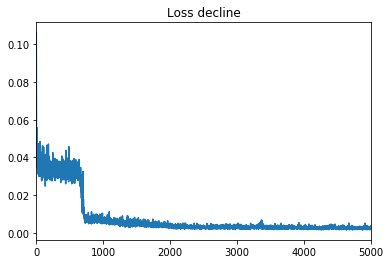

In [8]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(sn_list)-1)
            sub = sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss decline")
    save_path = saver.save(sess, modlepath)
    print("Model saved in file: %s" % save_path) 

# Calculate parameters using Vn1 dataset 

In [9]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')

    data = np.array(vn1_list)
    (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: data})

    err_vec = abs(input_ - output_).reshape(-1,step_num)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
    print("Got parameters mu and sigma.")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [10]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(vn2_list)//batch_num):
        normal_sub = np.array(vn2_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(va_list)//batch_num):
        abnormal_sub = np.array(va_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Finished')

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt
Model restored.
Initialized
Finished


In [11]:
# the threshold leads to best f1 sore
def evaluate(threshold):
    beta = 0.5
    tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
    fp = len(abnormal_score)-tp
    fn = np.array(normal_score)[np.array(normal_score)>threshold].size
    tn = len(normal_score)- fn
    P = tp/(tp+fp)
    R = tp/(tp+fn)
    fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
    return fbeta


upper = np.median(np.array(abnormal_score))
lower = np.median(np.array(normal_score)) 
scala = 20
delta = (upper-lower) / scala
candidate = lower
threshold = 0
result = 0

for _ in range(scala):
    r = evaluate(candidate)
    if r > result:
        result = r 
        threshold = candidate
    candidate += delta 

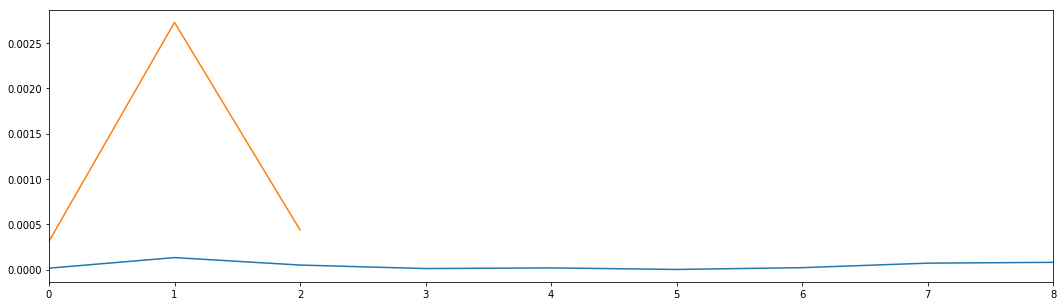

In [12]:
# anomaly score of vn2 and va dataset
pd.Series(normal_score).plot(figsize=(18,5))
pd.Series(abnormal_score).plot()

# test

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt
Model restored.
Initialized


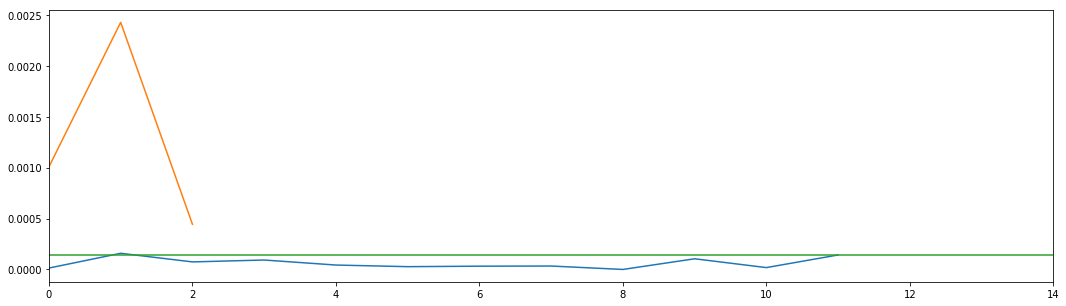

In [13]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

            
    pd.Series(normal_score).plot(label="normal_score",figsize=(18,5))
    pd.Series(abnormal_score).plot(label="abnormal_score")
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot(label="threshold")

# Evaluation

In [16]:
beta = 0.5
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

0.9375

In [17]:
print(tp,fp,tn,fn,P,R)

3 0 11 1 1.0 0.75
